# PPO for Lunar Lander
---

### 1. Import the Necessary Packages

In [1]:
import os
from model.ppo_rma import PPO
from env.wrappers import LunarContinuous, LunarLanderWithUnknownWind,LunarLanderWithKnownWind
from utils.logger import WandbSummaryWritter
from networks.mlp import MLP
import torch
from networks.adaptation_module import AdaptiveActorCritic
from networks.LSTMAdaptiveActorCritic import LSTMAdaptiveActorCritic

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
hyperparameters = {}

misc_hyperparameters = {
    'env': LunarLanderWithKnownWind,
    'base_encoder_class': MLP,
    'activation': torch.nn.Tanh,
    'adaptive_class': AdaptiveActorCritic,
}

Initialise wandb session in the code cell below.

In [3]:
LOG = False
if LOG:
    logger = WandbSummaryWritter(project='lunar', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [4]:
checkpoint = 'ppo_checkpoints/test7'
LOAD_MODEL = True

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/base.pth"))
    # ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adpt.pth"))
    ppo.adapt_policy.set_policy(ppo.policy)
    ppo.adapt_policy.to(ppo.device)

### 3. Train the Model

Train model for specified amount of timestamps.

In [5]:
ppo.train_adaptive_module_mlp()


-------------------- Iteration1/100 --------------------
Average adp Loss: 0.21958
Iteration took: 1.58 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.003
------------------------------------------------------


-------------------- Iteration2/100 --------------------
Average adp Loss: 0.19334
Iteration took: 1.42 secs, of which rollout took 0 secs and gradient updates took 0.0 secs
Current adp learning rate: 0.003
------------------------------------------------------



KeyboardInterrupt: 

In [13]:
i = 7
path = f"C:\\Users\\pmsar\\git\\tum-adlr-ws25-16\\ppo_checkpoints\\test{i}"
os.makedirs(path, exist_ok=True)
torch.save(ppo.policy.state_dict(), path + "\\base.pth")
torch.save(ppo.adpt_module.state_dict(), path + "\\adpt.pth")

### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [15]:
ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []

env = ppo.env_class(num_envs=1)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and (obs[0][-2] == 0 or obs[0][-3] == 0):
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action, adpt_output = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().flatten()[0]

    base_z.append(base_output)
    adpt_z.append(adpt_output.cpu().numpy())
    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
print(wind_vals[0], base_z[0])

140 [244.67892619]
-1.6499567 -0.0049640127


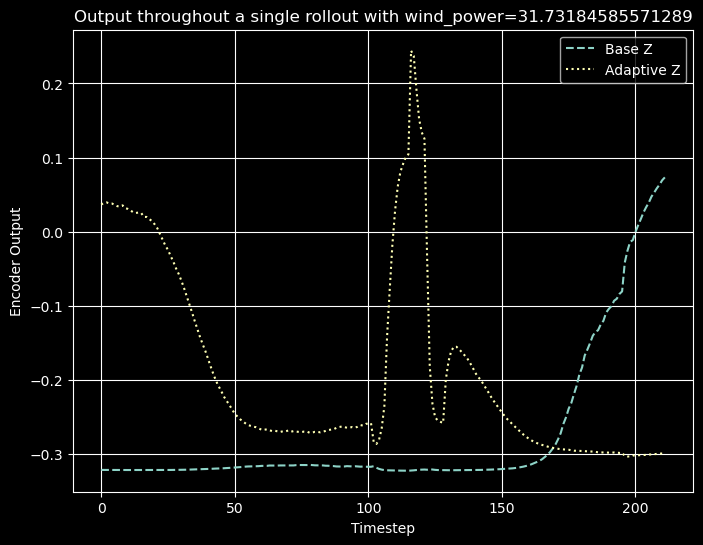

In [7]:
import matplotlib.pyplot as plt

indices = range(len(wind_vals))

plt.figure(figsize=(8, 6))
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with wind_power={wind_vals[0]}")
plt.legend()
plt.grid(True)

plt.show()

In [8]:
ENVS = 100
STEPS = 100
ppo.adapt_policy.clear_history()
adpt_policy = ppo.adapt_policy

env = ppo.env_class(num_envs=ENVS)

obs, done  = env.reset()
base_output = torch.zeros((STEPS, ENVS))
adpt_output = torch.zeros((STEPS, ENVS))
for step in range(STEPS):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    adpt_policy_action, z = adpt_policy.sample_action(obs_tensor)
    base_output[step] = ppo.policy.encoder(obs_tensor).cpu().detach().flatten()
    adpt_output[step] = z.cpu()

    obs, _, _ = env.step(adpt_policy_action.cpu().numpy())


t_winds = obs[:, -1]

obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)

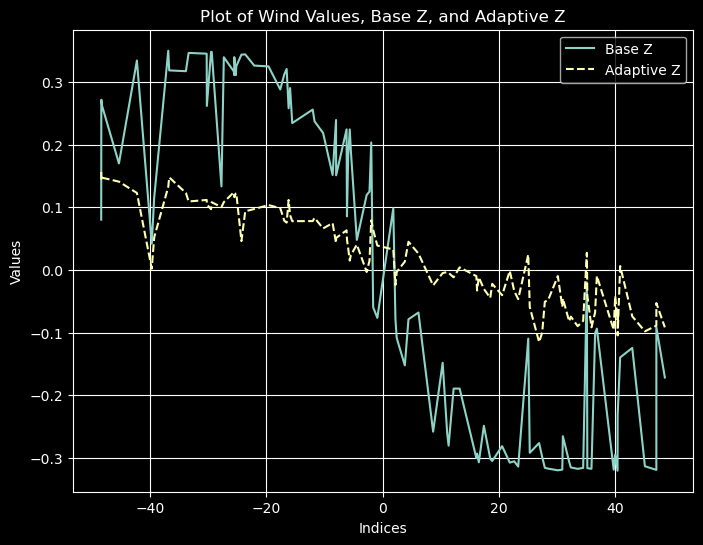

In [9]:
import numpy as np
t_winds, b_z, a_z = ppo.validate_encoders(100, 150)
sorted_indices = np.argsort(t_winds)
plt.figure(figsize=(8, 6))
plt.plot(t_winds[sorted_indices], b_z[sorted_indices], label="Base Z")
plt.plot(t_winds[sorted_indices], a_z[sorted_indices], label="Adaptive Z", linestyle='--')

plt.xlabel("Indices")
plt.ylabel("Values")
plt.title("Plot of Wind Values, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()